In [1]:
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


%matplotlib inline
import os
import pandas as pd
import requests
import json
import json
import os
import datetime

def load_ohlcv_data(symbol_list, interval_list, load_folder='data/raw'):
    loaded_data = {}

    for symbol in symbol_list:
        for interval in interval_list:
            current_load_path = os.path.join(load_folder, f'{symbol}_{interval}.json')

            # Check if the file exists
            if os.path.exists(current_load_path):
                # Load the data from the JSON file
                loaded_data[f'{symbol}_{interval}'] = pd.read_json(current_load_path)
                print(f"Data loaded for {symbol} - {interval} from {current_load_path}")
            else:
                print(f"No data file found for {symbol} - {interval} at {current_load_path}")

    return loaded_data



def fetch_ohlcv(symbol, interval, start_time, end_time):
    start_time = int(start_time.timestamp() * 1000) # Convert to milliseconds
    end_time = int(end_time.timestamp() * 1000) # Convert to milliseconds

    url = f"https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&startTime={start_time}&endTime={end_time}&limit=1000"

    raw_data = requests.get(url).text
    data = json.loads(raw_data)
    df = pd.DataFrame(data, columns=['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'ignored'])

    # Convert times to more readable format
    df['open_time'] = pd.to_datetime(df['open_time'], unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')

        # Convert prices and volume to float
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)

    df = df[['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time']]  # Keep only OHLCV data

    return df


def fetch_ohlcv_multi(symbol_list, interval_list, start_time, end_time, save_folder='data/raw'):
    # Create a directory for storing data files
    os.makedirs(save_folder, exist_ok=True)

    for symbol in symbol_list:
        for interval in interval_list:
            current_save_path = os.path.join(save_folder, f'{symbol}_{interval}.json')

            # Check if data already exists for this pair and timeframe
            #if os.path.exists(current_save_path):
            #    print(f"Data already exists for {symbol} - {interval}. Skipping...")
            #    continue

            # Initialize start time for each pair and interval
            current_start_time = start_time

            # Initialize an empty DataFrame for the current pair and interval
            full_data = pd.DataFrame()

            # Loop to fetch data in the required range
            while current_start_time < end_time:
                new_data = fetch_ohlcv(symbol, interval, current_start_time, end_time)
                
                if not new_data.empty:
                    full_data = pd.concat([full_data, new_data])
                    current_start_time = new_data.iloc[-1]['close_time']
                else:
                    print(f"No data returned for {symbol} - {interval} in the time range {current_start_time} to {end_time}")
                    break

            # Save the data to a JSON file
            full_data.to_json(current_save_path, orient='records', date_format='iso')
            print(f"Data saved for {symbol} - {interval} at {current_save_path}")

In [2]:
# scrap and save data to json files
# Example Usage:
symbol_list = ['BTCUSDT']#, 'BNBUSDT', 'ETHUSDT', 'MULTIUSDT', 'SOLUSDT', 'FIOUSDT', 'ALPINEUSDT', 'XRPUSDT']
interval_list = ['4h']

#start_time = datetime.datetime(2023, 12, 1, 0, 0, 0)
#end_time = datetime.datetime(2024, 1, 24, 6, 20, 0)

# Set start_time to UTC now minus one month
start_time = datetime.datetime.utcnow() - datetime.timedelta(days=30)
end_time = datetime.datetime.utcnow() 

fetch_ohlcv_multi(symbol_list, interval_list, start_time, end_time)

No data returned for BTCUSDT - 4h in the time range 2024-02-01 19:59:59.999000 to 2024-02-01 20:21:21.325841
Data saved for BTCUSDT - 4h at data/raw\BTCUSDT_4h.json


In [3]:

loaded_data = load_ohlcv_data(symbol_list, interval_list)

Data loaded for BTCUSDT - 4h from data/raw\BTCUSDT_4h.json


In [4]:
loaded_data['BTCUSDT_4h']

open_time      open      high       low     close       volume  \
0   2024-01-02 20:00:00  45039.49  45297.26  44600.00  44946.91   6655.56882   
1   2024-01-03 00:00:00  44946.91  45410.91  44862.11  45262.69   4750.68596   
2   2024-01-03 04:00:00  45262.70  45384.84  44940.93  45011.77   4691.11517   
3   2024-01-03 08:00:00  45011.77  45500.00  43500.00  43702.88  13237.52778   
4   2024-01-03 12:00:00  43702.89  43716.00  40750.00  43000.01  35484.15210   
..                  ...       ...       ...       ...       ...          ...   
175 2024-02-01 00:00:00  42580.00  42687.63  41884.28  42015.65   6159.26638   
176 2024-02-01 04:00:00  42015.65  42300.00  41889.95  42190.16   4812.74817   
177 2024-02-01 08:00:00  42190.15  42331.10  42026.52  42087.52   4002.75251   
178 2024-02-01 12:00:00  42087.52  42946.60  41944.89  42516.12   7858.34198   
179 2024-02-01 16:00:00  42516.12  43285.13  42364.00  43218.94   8083.56904   

                 close_time  
0   2024-01-02 23:59:59.999  
1   2024-01-03 03:59:59.999  
2   2024-01-03 07:59:59.999  
3   2024-01-03 11:59:59.999  
4   2024-01-03 15:59:59.999  
..                      ...  
175 2024-02-01 03:59:59.999  
176 2024-02-01 07:59:59.999  
177 2024-02-01 11:59:59.999  
178 2024-02-01 15:59:59.999  
179 2024-02-01 19:59:59.999  

[180 rows x 7 columns]

## candlestick charts

In [5]:
import mplfinance as mpf
import matplotlib.pyplot as plt


def plot_candlestick(data, symbol, interval):

    df = pd.DataFrame(data)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)

    # Plotting candlestick chart with volume
    mpf.plot(df, type='candle', style='charles', volume=True, title=f'Candlestick Chart with Volume - {symbol} - {interval}')
    
    plt.show()


def plot_candlestick_options(data, symbol, interval):

    df = pd.DataFrame(data)
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)

    # Define additional options
    customization_options = {
        'type': 'candle',
        'style': 'charles',
        'volume': True,
        'title': f'Candlestick Chart with Volume - {symbol} - {interval}',
        'mav': (10, 20),  # Moving averages
        'show_nontrading': True,  # Show non-trading days
        'addplot': [  # Additional plot (for example, moving averages)
            {'value': df['close'].rolling(window=10).mean(), 'color': 'blue', 'linestyle': 'dashed', 'width': 2}
        ],
        'savefig': 'chart.png',  # Save the chart as an image
        'block': False  # Do not block execution to show the chart interactively
    }

    # Plotting candlestick chart with volume and additional options
    mpf.plot(df, **customization_options)
    
    plt.show()


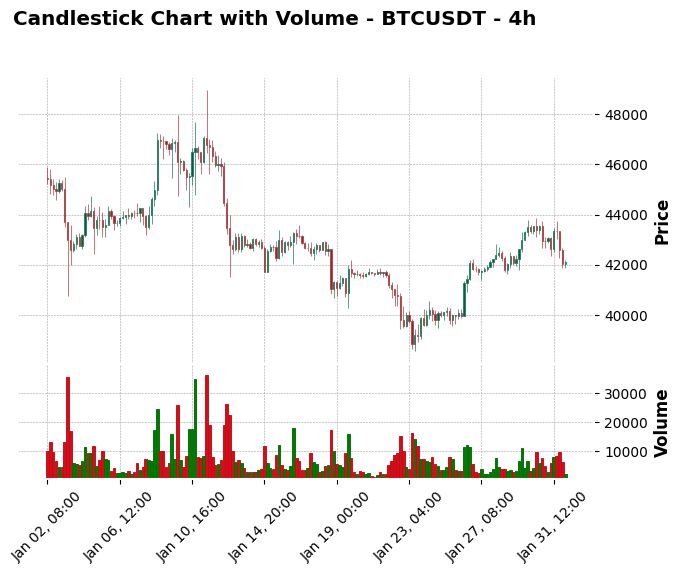

In [7]:
plot_candlestick(loaded_data['BTCUSDT_4h'], 'BTCUSDT', '4h')

'\nA simple example of TWO animated plots\n'

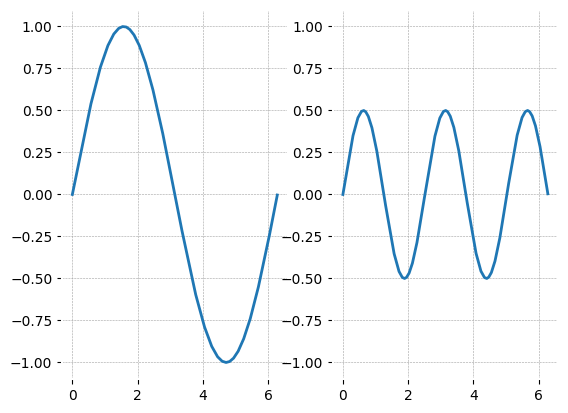

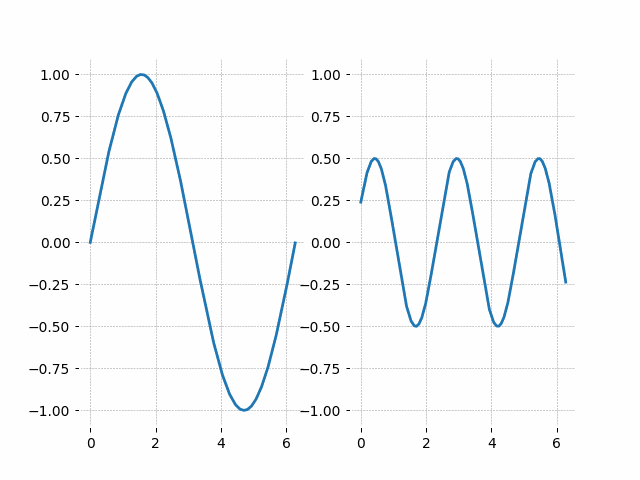

In [34]:
"""
A simple example of TWO animated plots
"""
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import display, Image

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2,sharey=ax1)

x = np.arange(0, 2*np.pi, 0.01)

line1, = ax1.plot(x, np.sin(x))
line2, = ax2.plot(x, 0.5*np.sin(2.5*(x)))

def animate1(i):
    line1.set_ydata(np.sin(x + i/10.0))  # update the data
    return line1,

def animate2(i):
    line2.set_ydata(0.5*np.sin(2.5*(x + i/5.0)))  # update the data
    return line2,

ani1 = animation.FuncAnimation(fig, animate1, np.arange(1, 200), interval=250)

ani2 = animation.FuncAnimation(fig, animate2, np.arange(1, 200), interval=75)

#plt.show()

f = r"animation.gif" 
writergif = animation.PillowWriter(fps=30) 
ani2.save(f, writer=writergif)

# Display the GIF
display(Image(filename=f))

(0.0, 1.0)

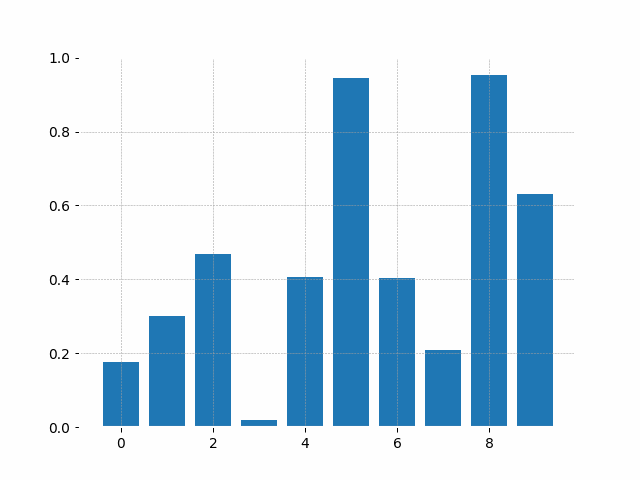

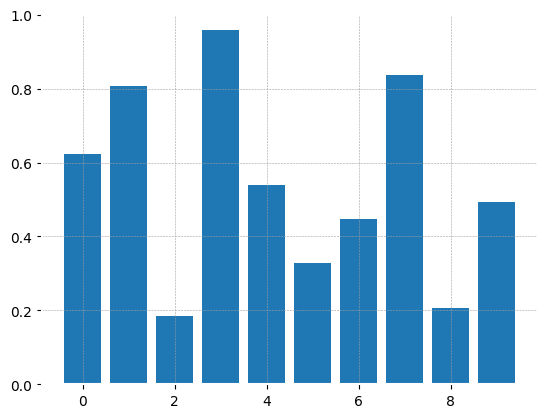

In [33]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from IPython.display import display, Image

# Create some sample data
data = np.random.rand(10)

# Create the initial bar chart
fig, ax = plt.subplots()
bars = ax.bar(range(len(data)), data)
ax.set_ylim(0, 1)  # Set y-axis limits based on your data range

# Function to update the bar chart in each animation frame
def animate(i):
    data[:] = np.random.rand(10)  # Update the data for each frame
    for bar, h in zip(bars, data):
        bar.set_height(h)
    return bars

# Create the animation
ani= animation.FuncAnimation(fig, animate, np.arange(1, 200), interval=150)
#plt.show()

f = r"animation.gif" 
writergif = animation.PillowWriter(fps=2) 
ani.save(f, writer=writergif)

# Display the GIF
display(Image(filename=f))


In [6]:
import pandas as pd
from d3blocks import D3Blocks

d3=D3Blocks()

[d3blocks] >INFO> Cleaning edge_properties and config parameters..


In [10]:
from d3blocks import D3Blocks
d3 = D3Blocks(verbose=30)
df = d3.import_example('energy')
d3.sankey(df, filepath=None, notebook=True)



c:\Projects\22-CryptoGPT\venv\Lib\site-packages\d3blocks\sankey\Sankey.py:189: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  config['fontsize'] = kwargs['node_properties']['fontsize'][0]
